In [5]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
#warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib

import pickle
import simplejson as json

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set a few plotting defaults
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18
plt.rcParams['patch.edgecolor'] = 'k'

pd.options.display.max_columns = 150

df = pd.read_csv("/users/akuppam/documents/Hprog/Py/rnb1015_2.csv")
df.head(5)

,date,region,marketing,visits,br,inq,gb,cb,nb,ss,ts,listings
0,1/1/16,AMR,NotPaid,1256288,6043,66022,6071,571,5500,485968.08000,144695.894200,10242216
1,1/1/16,AMR,Paid,189297,1092,11806,743,2,741,0.00000,14138.809600,2133795
2,1/1/16,UK,NotPaid,201797,435,9662,436,33,403,72698.92472,8317.105056,3561696
3,1/1/16,UK,Paid,55934,88,2749,61,1,60,0.00000,815.336426,890424
4,1/1/16,CE,NotPaid,200786,573,9250,435,31,404,40490.73159,12016.782410,3062480


In [6]:
df = df.loc[(df['region'] == 'AMR') & (df['marketing'] == 'NotPaid')]
df = df[~(df['nb'] < 0)]
df.describe()

,visits,br,inq,gb,cb,nb,ss,ts,listings
count,1.019000e+03,1019.000000,1019.000000,1019.000000,1019.000000,1019.000000,1.019000e+03,1.019000e+03,1.019000e+03
mean,1.502735e+06,11062.146222,46273.269872,10318.037291,1391.253189,8926.784102,4.111710e+05,1.104289e+06,1.336823e+07
std,3.439148e+05,3239.169146,24568.663358,2895.800768,480.532333,2558.088071,2.682106e+05,4.576828e+05,2.899904e+06
min,5.896950e+05,3820.000000,10363.000000,2732.000000,239.000000,2493.000000,-6.044689e+04,1.446959e+05,7.514140e+05
25%,1.239889e+06,8461.500000,26081.500000,8159.000000,1038.000000,6993.000000,2.583227e+05,7.365539e+05,1.136006e+07
50%,1.546179e+06,10555.000000,38585.000000,9988.000000,1359.000000,8567.000000,3.520192e+05,1.081944e+06,1.339582e+07
75%,1.767150e+06,13446.000000,62806.500000,12254.000000,1701.000000,10672.000000,4.627480e+05,1.404036e+06,1.503474e+07
max,2.433546e+06,21587.000000,118591.000000,21941.000000,5829.000000,16811.000000,3.151853e+06,2.401270e+06,1.803610e+07


In [9]:
p = q = range(2, 3) # Define the p and q parameters to take any value between 0 and 4 (incl 0, excl 4)
d = range(1,2) # Should not be more than 2
pdq = list(itertools.product(p, d, q)) # Combinations of p, d and q
pdq_x_PDQ = [(x[0], x[1], x[2], 365) for x in list(itertools.product(p, d, q))] # Combinations of seasonal P, D and Q
print(pdq)
print(pdq_x_PDQ)

[(2, 1, 2)]
[(2, 1, 2, 365)]


In [12]:
import warnings					
warnings.filterwarnings("ignore")					
					
model_params = []					
for param in pdq:					
    for seasonal_param in pdq_x_PDQ:					
        try:					
            mod = sm.tsa.statespace.SARIMAX(df['nb'],					
                                            trend='ct',					
                                            order=param,					
                                            seasonal_order=seasonal_param,					
                                            enforce_stationarity=False,					
                                            enforce_invertibility=False)					
            results = mod.fit()					
            print('SARIMA{}x{} - AIC:{}'.format(param, seasonal_param, results.aic))					
            model_params.append(param, seasonal_param, results.aic)					
        except:					
            continue					
					
pdq1 = []
PDQ1 = []
model_params.sort(key = lambda tup:tup[2])					
for sublist in model_params[:1]:					
    pdq1 = (sublist[:1])					
order = pdq1
for sublist in model_params[:1]:					
    PDQ1 = (sublist[:2])					
sorder = PDQ1
					
print('best order = ', order)					
print('best sorder = ', sorder)					
           					
mod = sm.tsa.statespace.SARIMAX(df['nb'], 					
                                trend='ct', 					
                                order=order, 					
                                seasonal_order=sorder, 					
                                enforce_stationarity=False, 					
                                enforce_invertibility=False)					
results = mod.fit()					
print(results.summary())					
					

# Plot 'real' vs. 'predictions'
import numpy as np
X = df['nb']
history = [x for x in X]
predictions = list()
for t in range(len(X)):
    mod = sm.tsa.statespace.SARIMAX(df['nb'],
                                    trend='ct',
                                    order=order,
                                    seasonal_order=sorder,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
    model_fit = mod.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = X[t]
    history.append(obs)
# plot
pyplot.plot(X)
pyplot.plot(predictions, color='red')
#pyplot.show()
pyplot.savefig('SARIMA - real vs predictions.png')
    
# compute MAPE
pf = pd.DataFrame(predictions)
xf = pd.DataFrame(X)
dff = pd.concat([pf,xf],axis=1)
dff.columns = ['predict_sarima', 'real']
dff['abspctdiff'] = abs(dff['predict_sarima']-dff['real'])/dff['real']
mape_sarima = np.mean(dff['abspctdiff'])
print("mape_sarima = ", mape_sarima)
    
h = 442					
forecast = results.forecast(h)					
forecast.plot()					

best order =  []
best sorder =  []


IndexError: list index out of range

In [101]:
y = mod.fit(df['nb'])

In [110]:
print(mod.fit())

In [114]:
history = [x for x in df['nb']]

In [111]:
mod = sm.tsa.statespace.SARIMAX(df['nb'], 					
                                trend='ct', 					
                                order=order, 					
                                seasonal_order=sorder, 					
                                enforce_stationarity=False, 					
                                enforce_invertibility=False)					

In [113]:
history = [x for x in df['nb']]
mod = sm.tsa.statespace.SARIMAX(df['nb'], 					
                                trend='ct', 					
                                order=order, 					
                                seasonal_order=sorder, 					
                                enforce_stationarity=False, 					
                                enforce_invertibility=False)					
model_fit = mod.fit(disp=False)
yhat = model_fit.predict(len(history), len(history))

In [115]:
yhat = model_fit.predict(len(history), len(history))

In [116]:
yhat

1019    7954.10678
dtype: float64

In [4]:
yhat

NameError: name 'yhat' is not defined

In [112]:
results = mod.fit()					
print(results.summary())					

                                 Statespace Model Results                                 
Dep. Variable:                                 nb   No. Observations:                 1019
Model:             SARIMAX(1, 0, 2)x(2, 0, 2, 12)   Log Likelihood               -8085.530
Date:                            Fri, 09 Nov 2018   AIC                          16191.059
Time:                                    10:57:58   BIC                          16240.057
Sample:                                         0   HQIC                         16209.689
                                           - 1019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    357.7374    163.335      2.190      0.029      37.606     677.868
drift          0.3127      0.167   

In [5]:
X = df['nb']

In [10]:
# Plot 'real' vs. 'predictions'
import warnings
warnings.filterwarnings("ignore")

import numpy as np
X = df['nb']
history = [x for x in X]
predictions = list()
for t in range(len(X)):
    mod = sm.tsa.statespace.SARIMAX(df['nb'],
                                    trend='ct',
                                    order=(1,0,1),
                                    seasonal_order=(1,0,1,12),
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
    model_fit = mod.fit(disp=False)
    #yhat = model_fit.predict(len(history), len(history))
    yhat = model_fit.forecast()
    print(yhat)
    predictions.append(yhat)

1019    7974.985335
dtype: float64
1019    7974.985335
dtype: float64
1019    7974.985335
dtype: float64
1019    7974.985335
dtype: float64
1019    7974.985335
dtype: float64
1019    7974.985335
dtype: float64
1019    7974.985335
dtype: float64
1019    7974.985335
dtype: float64
1019    7974.985335
dtype: float64
1019    7974.985335
dtype: float64
1019    7974.985335
dtype: float64
1019    7974.985335
dtype: float64
1019    7974.985335
dtype: float64
1019    7974.985335
dtype: float64
1019    7974.985335
dtype: float64
1019    7974.985335
dtype: float64
1019    7974.985335
dtype: float64
1019    7974.985335
dtype: float64
1019    7974.985335
dtype: float64
1019    7974.985335
dtype: float64
1019    7974.985335
dtype: float64
1019    7974.985335
dtype: float64
1019    7974.985335
dtype: float64
1019    7974.985335
dtype: float64
1019    7974.985335
dtype: float64
1019    7974.985335
dtype: float64
1019    7974.985335
dtype: float64
1019    7974.985335
dtype: float64
1019    7974.985335


KeyboardInterrupt: 

In [8]:
predictions

[1019    7974.985335
 dtype: float64, 1019    7974.985335
 dtype: float64, 1019    7974.985335
 dtype: float64, 1019    7974.985335
 dtype: float64, 1019    7974.985335
 dtype: float64, 1019    7974.985335
 dtype: float64, 1019    7974.985335
 dtype: float64, 1019    7974.985335
 dtype: float64, 1019    7974.985335
 dtype: float64, 1019    7974.985335
 dtype: float64, 1019    7974.985335
 dtype: float64, 1019    7974.985335
 dtype: float64, 1019    7974.985335
 dtype: float64, 1019    7974.985335
 dtype: float64, 1019    7974.985335
 dtype: float64, 1019    7974.985335
 dtype: float64, 1019    7974.985335
 dtype: float64, 1019    7974.985335
 dtype: float64, 1019    7974.985335
 dtype: float64, 1019    7974.985335
 dtype: float64, 1019    7974.985335
 dtype: float64, 1019    7974.985335
 dtype: float64, 1019    7974.985335
 dtype: float64, 1019    7974.985335
 dtype: float64, 1019    7974.985335
 dtype: float64, 1019    7974.985335
 dtype: float64, 1019    7974.985335
 dtype: float64, 

In [96]:
output

1019    7954.10678
dtype: float64

In [ ]:
df['A'].iloc[0]

In [97]:
output.iloc[0]

7954.106780040627

In [4]:
import warnings
warnings.filterwarnings("ignore")

model_params = []
model_params1 = []
model_params2 = []
for param in pdq:
    for seasonal_param in pdq_x_PDQ:
        try:
            mod = sm.tsa.statespace.SARIMAX(df['nb'],
                                            trend='ct',
                                            order=(3,0,3),
                                            seasonal_order=(0,0,3,12),
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            #model_params.append(param, seasonal_param, results.aic)
            print('SARIMA{}x{} - AIC:{}'.format(param, seasonal_param, results.aic))
            model_params.append(param)
            model_params1.append(seasonal_param)
            model_params2.append(results.aic)
        except:
            continue

SARIMA(0, 0, 0)x(0, 0, 0, 12) - AIC:15909.195829920116
SARIMA(0, 0, 0)x(0, 0, 1, 12) - AIC:15909.195829920116
SARIMA(0, 0, 0)x(1, 0, 0, 12) - AIC:15909.195829920116
SARIMA(0, 0, 0)x(1, 0, 1, 12) - AIC:15909.195829920116
SARIMA(0, 0, 1)x(0, 0, 0, 12) - AIC:15909.195829920116
SARIMA(0, 0, 1)x(0, 0, 1, 12) - AIC:15909.195829920116
SARIMA(0, 0, 1)x(1, 0, 0, 12) - AIC:15909.195829920116
SARIMA(0, 0, 1)x(1, 0, 1, 12) - AIC:15909.195829920116
SARIMA(1, 0, 0)x(0, 0, 0, 12) - AIC:15909.195829920116
SARIMA(1, 0, 0)x(0, 0, 1, 12) - AIC:15909.195829920116
SARIMA(1, 0, 0)x(1, 0, 0, 12) - AIC:15909.195829920116
SARIMA(1, 0, 0)x(1, 0, 1, 12) - AIC:15909.195829920116
SARIMA(1, 0, 1)x(0, 0, 0, 12) - AIC:15909.195829920116
SARIMA(1, 0, 1)x(0, 0, 1, 12) - AIC:15909.195829920116
SARIMA(1, 0, 1)x(1, 0, 0, 12) - AIC:15909.195829920116
SARIMA(1, 0, 1)x(1, 0, 1, 12) - AIC:15909.195829920116


In [57]:
seasonal_param

(1, 0, 1, 12)

In [58]:
results.aic

16689.940491783953

In [59]:
model_params

[(0, 0, 0),
 (0, 0, 0),
 (0, 0, 0),
 (0, 0, 0),
 (0, 0, 1),
 (0, 0, 1),
 (0, 0, 1),
 (0, 0, 1),
 (1, 0, 0),
 (1, 0, 0),
 (1, 0, 0),
 (1, 0, 0),
 (1, 0, 1),
 (1, 0, 1),
 (1, 0, 1),
 (1, 0, 1)]

In [60]:
model_params1

[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (0, 0, 0, 12),
 (0, 0, 1, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (0, 0, 0, 12),
 (0, 0, 1, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (0, 0, 0, 12),
 (0, 0, 1, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12)]

In [61]:
model_params2

[18664.721004689716,
 17972.260801425862,
 18331.974750087593,
 17960.465788447324,
 17757.991765552724,
 17307.467273367347,
 17478.082883347564,
 17303.405160193055,
 16923.37078204938,
 16701.967325071484,
 16709.480198152145,
 16703.807372802174,
 16906.16743259115,
 16688.163206466877,
 16710.594435592073,
 16689.940491783953]

In [70]:
model_zip = tuple(zip(model_params, model_params1, model_params2))

In [71]:
model_zip

(((0, 0, 0), (0, 0, 0, 12), 18664.721004689716),
 ((0, 0, 0), (0, 0, 1, 12), 17972.260801425862),
 ((0, 0, 0), (1, 0, 0, 12), 18331.974750087593),
 ((0, 0, 0), (1, 0, 1, 12), 17960.465788447324),
 ((0, 0, 1), (0, 0, 0, 12), 17757.991765552724),
 ((0, 0, 1), (0, 0, 1, 12), 17307.467273367347),
 ((0, 0, 1), (1, 0, 0, 12), 17478.082883347564),
 ((0, 0, 1), (1, 0, 1, 12), 17303.405160193055),
 ((1, 0, 0), (0, 0, 0, 12), 16923.37078204938),
 ((1, 0, 0), (0, 0, 1, 12), 16701.967325071484),
 ((1, 0, 0), (1, 0, 0, 12), 16709.480198152145),
 ((1, 0, 0), (1, 0, 1, 12), 16703.807372802174),
 ((1, 0, 1), (0, 0, 0, 12), 16906.16743259115),
 ((1, 0, 1), (0, 0, 1, 12), 16688.163206466877),
 ((1, 0, 1), (1, 0, 0, 12), 16710.594435592073),
 ((1, 0, 1), (1, 0, 1, 12), 16689.940491783953))

In [76]:
#best = sorted(listOfScores, key=lambda x: x[0])
best = sorted(model_zip, key=lambda x: x[2])

In [77]:
best

[((1, 0, 1), (0, 0, 1, 12), 16688.163206466877),
 ((1, 0, 1), (1, 0, 1, 12), 16689.940491783953),
 ((1, 0, 0), (0, 0, 1, 12), 16701.967325071484),
 ((1, 0, 0), (1, 0, 1, 12), 16703.807372802174),
 ((1, 0, 0), (1, 0, 0, 12), 16709.480198152145),
 ((1, 0, 1), (1, 0, 0, 12), 16710.594435592073),
 ((1, 0, 1), (0, 0, 0, 12), 16906.16743259115),
 ((1, 0, 0), (0, 0, 0, 12), 16923.37078204938),
 ((0, 0, 1), (1, 0, 1, 12), 17303.405160193055),
 ((0, 0, 1), (0, 0, 1, 12), 17307.467273367347),
 ((0, 0, 1), (1, 0, 0, 12), 17478.082883347564),
 ((0, 0, 1), (0, 0, 0, 12), 17757.991765552724),
 ((0, 0, 0), (1, 0, 1, 12), 17960.465788447324),
 ((0, 0, 0), (0, 0, 1, 12), 17972.260801425862),
 ((0, 0, 0), (1, 0, 0, 12), 18331.974750087593),
 ((0, 0, 0), (0, 0, 0, 12), 18664.721004689716)]

In [79]:
model_zip = tuple(zip(model_params, model_params1, model_params2))
best = sorted(model_zip, key=lambda x: x[2])

pdq1 = []
for sublist in best[:1]:
    pdq1 = (sublist[:1])
order = pdq1
PDQ1 = []
for sublist in best[:1]:
    PDQ1 = (sublist[:2])
sorder = PDQ1

print('best order = ', order)
print('best sorder = ', sorder)

best order =  ((1, 0, 1),)
best sorder =  ((1, 0, 1), (0, 0, 1, 12))


In [ ]:
model_params.sort(key = lambda tup:tup[2])
pdq1 = ()
for sublist in model_params[:1]:
    pdq1 = (sublist[:1])
order = pdq1
PDQ1 = []
for sublist in model_params[:1]:
    PDQ1 = (sublist[:2])
sorder = PDQ1

print('best order = ', order)
print('best sorder = ', sorder)

In [29]:
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                 nb   No. Observations:                 1019
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood               -8337.970
Date:                            Fri, 09 Nov 2018   AIC                          16689.940
Time:                                    07:44:16   BIC                          16724.330
Sample:                                         0   HQIC                         16703.008
                                           - 1019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    696.1035    208.916      3.332      0.001     286.635    1105.572
drift          0.2753      0.139   

In [22]:
model_params.sort(key = lambda tup:tup[2])
pdq1 = ()
for sublist in model_params[:1]:
    pdq1 = (sublist[:1])
order = pdq1(0)
PDQ1 = []
for sublist in model_params[:1]:
    PDQ1 = (sublist[:2])
sorder = PDQ1

print('best order = ', order)
print('best sorder = ', sorder)

TypeError: 'tuple' object is not callable

In [23]:
model_params

[]

In [ ]:
get X vs predictions
compute mapes
join real, forecasts (like in HW code)
plot real+forecasts
AND THEN DO A GRID SEARCH (0,4 // 0,2)

In [33]:
out_param

[0, 1, 0]

In [11]:
p = q = range(0, 2) # Define the p and q parameters to take any value between 0 and 4 (incl 0, excl 4)
d = range(0,1) # Should not be more than 2
pdq = list(itertools.product(p, d, q)) # Combinations of p, d and q
pdq_x_PDQ = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))] # Combinations of seasonal P, D and Q
print(pdq)
print(pdq_x_PDQ)

import warnings
warnings.filterwarnings("ignore")

model_params = []
for param in pdq:
    for seasonal_param in pdq_x_PDQ:
        try:
            mod = sm.tsa.statespace.SARIMAX(df['nb'],
                                            trend='ct',
                                            order=param,
                                            seasonal_order=seasonal_param,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('SARIMA{}x{} - AIC:{}'.format(param, seasonal_param, results.aic))
            model_params.append((param, seasonal_param, results.aic))
        except:
            continue

[(0, 0, 0), (0, 0, 1), (1, 0, 0), (1, 0, 1)]
[(0, 0, 0, 12), (0, 0, 1, 12), (1, 0, 0, 12), (1, 0, 1, 12)]
SARIMA(0, 0, 0)x(0, 0, 0, 12) - AIC:18664.721004689716
SARIMA(0, 0, 0)x(0, 0, 1, 12) - AIC:17972.260801425862
SARIMA(0, 0, 0)x(1, 0, 0, 12) - AIC:18331.974750087593
SARIMA(0, 0, 0)x(1, 0, 1, 12) - AIC:17960.465788447324
SARIMA(0, 0, 1)x(0, 0, 0, 12) - AIC:17757.991765552724
SARIMA(0, 0, 1)x(0, 0, 1, 12) - AIC:17307.467273367347
SARIMA(0, 0, 1)x(1, 0, 0, 12) - AIC:17478.082883347564
SARIMA(0, 0, 1)x(1, 0, 1, 12) - AIC:17303.405160193055
SARIMA(1, 0, 0)x(0, 0, 0, 12) - AIC:16923.37078204938
SARIMA(1, 0, 0)x(0, 0, 1, 12) - AIC:16701.967325071484
SARIMA(1, 0, 0)x(1, 0, 0, 12) - AIC:16709.480198152145
SARIMA(1, 0, 0)x(1, 0, 1, 12) - AIC:16703.807372802174
SARIMA(1, 0, 1)x(0, 0, 0, 12) - AIC:16906.16743259115
SARIMA(1, 0, 1)x(0, 0, 1, 12) - AIC:16688.163206466877
SARIMA(1, 0, 1)x(1, 0, 0, 12) - AIC:16710.594435592073
SARIMA(1, 0, 1)x(1, 0, 1, 12) - AIC:16689.940491783953


In [12]:
model_params

[((0, 0, 0), (0, 0, 0, 12), 18664.721004689716),
 ((0, 0, 0), (0, 0, 1, 12), 17972.260801425862),
 ((0, 0, 0), (1, 0, 0, 12), 18331.974750087593),
 ((0, 0, 0), (1, 0, 1, 12), 17960.465788447324),
 ((0, 0, 1), (0, 0, 0, 12), 17757.991765552724),
 ((0, 0, 1), (0, 0, 1, 12), 17307.467273367347),
 ((0, 0, 1), (1, 0, 0, 12), 17478.082883347564),
 ((0, 0, 1), (1, 0, 1, 12), 17303.405160193055),
 ((1, 0, 0), (0, 0, 0, 12), 16923.37078204938),
 ((1, 0, 0), (0, 0, 1, 12), 16701.967325071484),
 ((1, 0, 0), (1, 0, 0, 12), 16709.480198152145),
 ((1, 0, 0), (1, 0, 1, 12), 16703.807372802174),
 ((1, 0, 1), (0, 0, 0, 12), 16906.16743259115),
 ((1, 0, 1), (0, 0, 1, 12), 16688.163206466877),
 ((1, 0, 1), (1, 0, 0, 12), 16710.594435592073),
 ((1, 0, 1), (1, 0, 1, 12), 16689.940491783953)]

In [13]:
model_params.sort(key = lambda tup:tup[2])
for sublist in model_params[:1]:
    pdq = (sublist[:1])
order = pdq[0]
for sublist in model_params[:1]:
    PDQ = (sublist[:2])
sorder = PDQ[1]

In [14]:
order

(1, 0, 1)

In [15]:
sorder

(0, 0, 1, 12)

In [16]:
mod = sm.tsa.statespace.SARIMAX(df['nb'], 					
                                trend='ct', 					
                                order=order, 					
                                seasonal_order=sorder, 					
                                enforce_stationarity=False, 					
                                enforce_invertibility=False)					
results = mod.fit()					
print(results.summary())					

                                 Statespace Model Results                                 
Dep. Variable:                                 nb   No. Observations:                 1019
Model:             SARIMAX(1, 0, 1)x(0, 0, 1, 12)   Log Likelihood               -8338.082
Date:                            Fri, 09 Nov 2018   AIC                          16688.163
Time:                                    15:47:26   BIC                          16717.640
Sample:                                         0   HQIC                         16699.364
                                           - 1019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    696.1039    117.575      5.921      0.000     465.661     926.546
drift          0.2825      0.115   

In [ ]:
# Plot 'real' vs. 'predictions'
import numpy as np
X = series.values
history = [x for x in X]
predictions = list()
for t in range(len(X)):
	model = ARIMA(history, order=(p,d,q))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = X[t]
	history.append(obs)
# plot
pyplot.plot(X)
pyplot.plot(predictions, color='red')
#pyplot.show()
pyplot.savefig('real vs predictions.png')

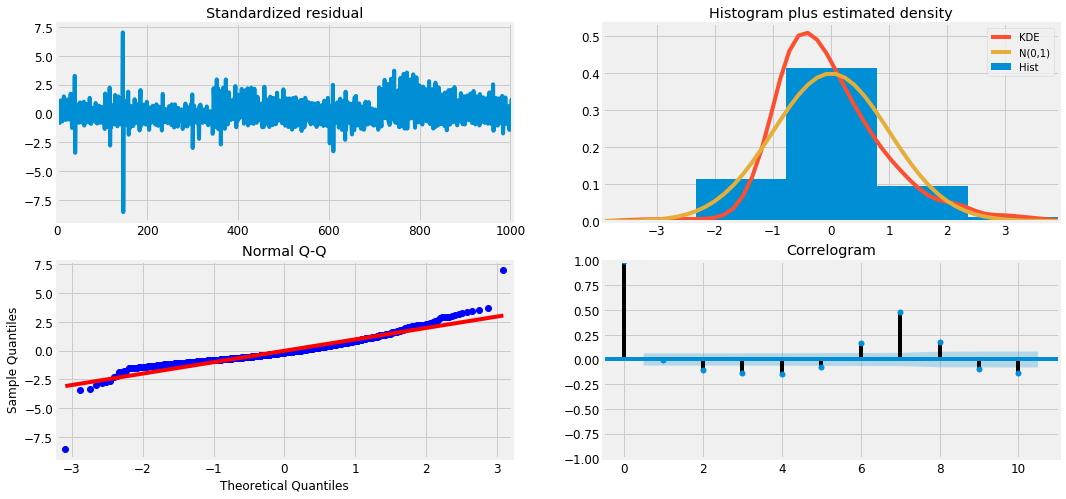

In [21]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

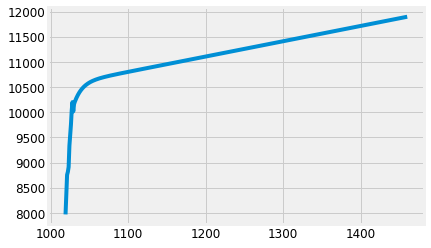

In [24]:
h = 442
forecast = results.forecast(h)
forecast.plot()

In [25]:
pred = results.get_prediction(start = 1019, end = 1461, dynamic=False)
pred_ci = pred.conf_int()
pred_ci.head()

,lower nb,upper nb
1019,6047.310999,9890.444140
1020,5747.158247,11037.165218
1021,5638.022875,11871.509999
1022,5356.941582,12270.798604
1023,5198.081957,12625.122793


In [27]:
nb_forecast = pred.predicted_mean  # this only has the forecasted 120 time points
nb_truth = df['nb']  # this is the observed data 998 time points

# Compute the mean square error
mse = ((nb_forecast - nb_truth) ** 2).mean()
print('The Mean Squared Error (MSE) of the forecast is {}'.format(round(mse, 2)))
print('The Root Mean Square Error (RMSE) of the forecast: {:.4f}'
      .format(np.sqrt(sum((nb_forecast-nb_truth)**2)/len(nb_forecast))))

The Mean Squared Error (MSE) of the forecast is 19212487.8
The Root Mean Square Error (RMSE) of the forecast: nan


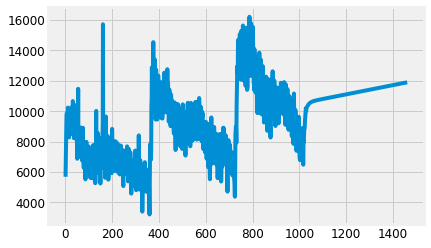

In [33]:
pred_fcst = results.predict(start=1, end=1461, dynamic=False)
plt.plot(pred_fcst)

In [20]:
# Plot 'real' vs. 'predictions'
import numpy as np
X = df['nb']
history = [x for x in X]
predictions = list()
for t in range(len(X)):
    mod = sm.tsa.statespace.SARIMAX(df['nb'],
                                    trend='ct',
                                    order=order,
                                    seasonal_order=sorder,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
    model_fit = mod.fit(transparams=True)
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(X[t])
# plot
pyplot.plot(X)
pyplot.plot(predictions, color='red')
#pyplot.show()
pyplot.savefig('SARIMA - real vs predictions.png')

KeyError: 0

In [66]:
model_params[:1]

[((0, 0, 0), (0, 0, 0, 12), 190167.48485213058)]

In [57]:
model_params[0:]

[((0, 0, 0), (0, 0, 0, 12), 190167.48485213058),
 ((0, 1, 0), (0, 0, 0, 12), 195834.80496667878),
 ((0, 0, 0), (0, 1, 0, 12), 197946.04040928202),
 ((0, 1, 0), (0, 1, 0, 12), 203388.29272818004)]

In [80]:
for sublist in model_params[:1]:
    pdq = (sublist[:1])
pdq[0]

(0, 0, 0)

In [87]:
for sublist in model_params[:1]:
    PDQ = (sublist[:2])
PDQ[1]

(0, 0, 0, 12)

In [40]:
print('SARIMA{}x{} - AIC:{}'.format(param, seasonal_param, results.aic))

SARIMA(1, 1, 1)x(1, 1, 1, 12) - AIC:17299.422363435377


In [21]:
results.aic

16799.53373250593

In [19]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                 nb   No. Observations:                 1019
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -8392.767
Date:                            Thu, 08 Nov 2018   AIC                          16799.534
Time:                                    11:57:46   BIC                          16833.832
Sample:                                         0   HQIC                         16812.574
                                           - 1019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.0337      2.524      0.410      0.682      -3.914       5.981
drift         -0.0021      0.005     -0.457      0.648      -0.011       0.007
ar.L1          0.5661      0.103      5.472      0.000       0.363       0.769
ma.L1         -0.8458      0.072    -11.771      0.000      -0.987      -0.705
ar.S.L12      -0.1455      0.088     -1.649      0.099      -0.318       0.027
ma.S.L12      -0.9628      0.053    -18.329      0.000      -1.066      -0.860
sigma2      2.354e+06    5.8e-06   4.06e+11      0.000    2.35e+06    2.35e+06
===================================================================================
Ljung-Box (Q):                     2044.68   Jarque-Bera (JB):              1247.09
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.15   Skew:                             0.65
Prob(H) (two-sided):                  0.21   Kurtosis:                         8.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.49e+27. Standard errors may be unstable.
"""

In [24]:
out_param

<_io.TextIOWrapper name='param.json' mode='w' encoding='UTF-8'>

In [ ]:
import warnings
import pandas as pd
import numpy as np
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import statsmodels.api as sm

# evaluate a SARIMA model for a given order (p,d,q), (P,D,Q), n (seasons)
def evaluate_sarima_model(X, order, sorder, n):
	history = [x for x in X]
	# make predictions
	predictions = list()
	for t in range(len(X)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit(transparams=True)
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(X[t])
	# calculate out of sample error
	error = mean_squared_error(X, predictions)
	mape = np.mean(abs((X-predictions)/X))
	return error
	return mape

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_params = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					mse = evaluate_arima_model(dataset, order)
					if mse < best_score:
						best_score, best_params = mse, order
					print('ARIMA %s MSE=%.3f' % (order,mse))
				except:
					continue
	print('Best ARIMA %s MSE=%.3f' % (best_params, best_score))
	model_params = [p,d,q]
	print("best order =", model_params)
	with open('model_params.json','w') as out_params:
		json.dump(model_params, out_params)

# load dataset
series = df['nb']

# evaluate parameters
# 3,2,2 is good (no need to incr d > 2)
p_values = range(0, 4)
d_values = range(0, 2)
q_values = range(0, 4)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

# select the best set of p,d,q
with open('model_params.json') as json_file:
    out_params = json.load(json_file)
out_params
p = out_params[0]
d = out_params[1]
q = out_params[2]

# apply model
model = ARIMA(series, order=(p,d,q))
model_fit = model.fit(transparams=True)
print(model_fit.summary())

# plot residual errors
#residuals = pd.DataFrame(model_fit.resid)
#residuals.plot()
#pyplot.show()
#residuals.plot(kind='kde')
#pyplot.show()
#plt.savefig('residuals.png')
#print(residuals.describe())

# Plot 'real' vs. 'predictions'
import numpy as np
X = series.values
history = [x for x in X]
predictions = list()
for t in range(len(X)):
	model = ARIMA(history, order=(p,d,q))
	model_fit = model.fit(transparams=True)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = X[t]
	history.append(obs)
# plot
plt.plot(X)
plt.plot(predictions, color='red')
#pyplot.show()
plt.savefig('real vs predictions.png')

# compute MAPE
pf = pd.DataFrame(predictions)
xf = pd.DataFrame(X)
dff = pd.concat([pf,xf],axis=1)
dff.columns = ['predict_arima', 'real']
dff['abspctdiff'] = abs(dff['predict_arima']-dff['real'])/dff['real']
mape_arima = np.mean(dff['abspctdiff'])
print("mape_arima = ", mape_arima)

# Get forecast 442 steps ahead in future (10/15/2018 to 12/31/2019)
pred_forecast = model_fit.forecast(steps=442)
pdf = pd.DataFrame(pred_forecast[0])
pdf.to_csv("forecasts_arima.csv")

In [ ]:
### pip install pyramid-arima (make sure to vpn to hmwy network)

from pyramid.arima import auto_arima
stepwise_model = auto_arima(data, start_p=0, start_q=0,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())